In [1]:
!pip install kagglehub --upgrade

In [2]:
import kagglehub

In [3]:
# download the dataset from kaggle

kagglehub.dataset_download("undefinenull/million-song-dataset-spotify-lastfm")

100%|██████████| 639M/639M [00:07<00:00, 94.6MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/undefinenull/million-song-dataset-spotify-lastfm/versions/1'

In [4]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
data_path = Path("/root/.cache/kagglehub/datasets/undefinenull/million-song-dataset-spotify-lastfm/versions/1")


songs_data_path = data_path / 'Music Info.csv'
users_data_path = data_path / 'User Listening History.csv'

In [6]:
# songs_data

songs_df = pd.read_csv(songs_data_path, usecols=["track_id","name","artist","spotify_preview_url"])

songs_df.head()

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
2,TROUVHL128F426C441,Come as You Are,Nirvana,https://p.scdn.co/mp3-preview/a1c11bb1cb231031...
3,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
4,TRLNZBD128F935E4D8,Creep,Radiohead,https://p.scdn.co/mp3-preview/e7eb60e9466bc3a2...


In [7]:
!pip install dask[dataframe]

In [8]:
import dask.dataframe as dd

# Load the dataset
df = dd.read_csv(users_data_path)

# Check the first few rows to verify the data
df.head()

,track_id,user_id,playcount
0,TRIRLYL128F42539D1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
1,TRFUPBA128F934F7E1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
2,TRLQPQJ128F42AA94F,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
3,TRTUCUY128F92E1D24,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1
4,TRHDDQG12903CB53EE,b80344d063b5ccb3212f76538f3d9e43d87dca9e,1


In [9]:
df.npartitions

9

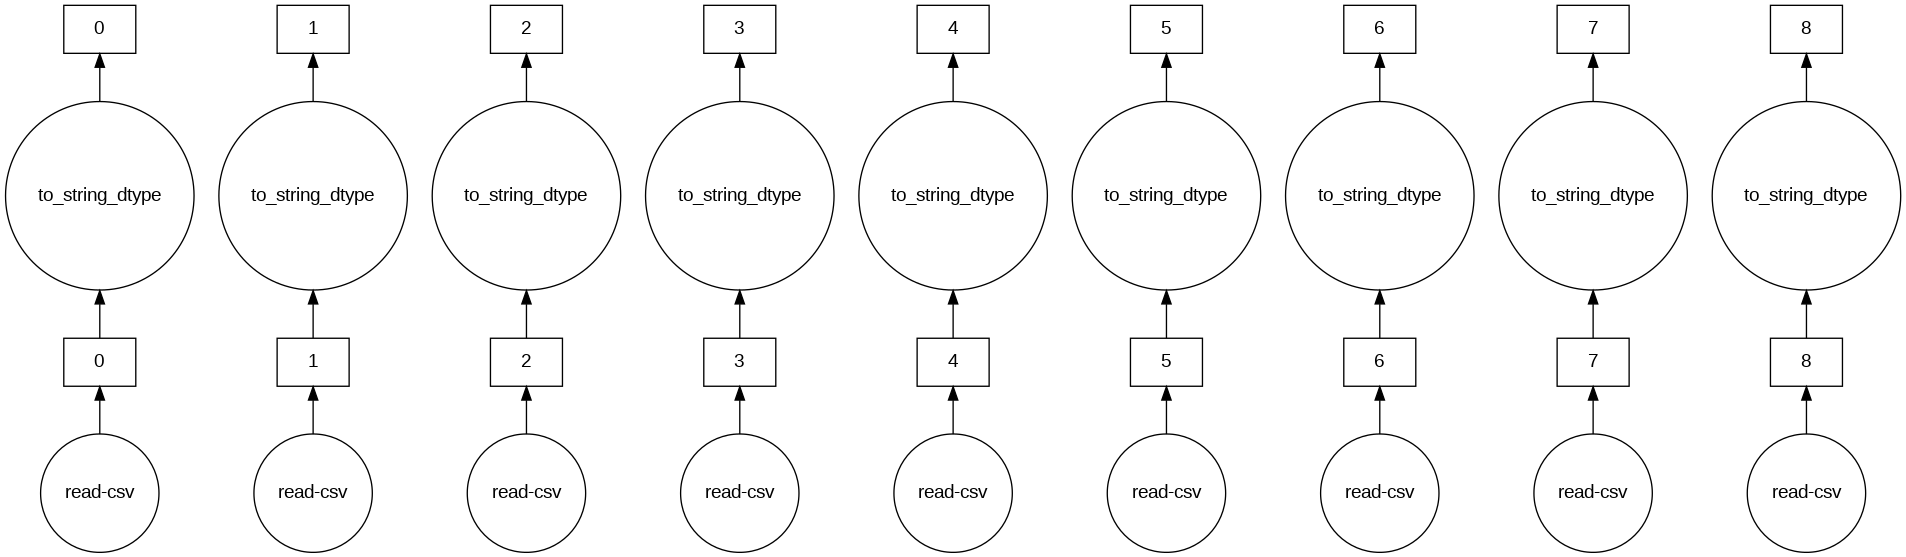

In [10]:
df.visualize(tasks=True)

In [11]:
# number of unique tracks in the data

unique_tracks = df.loc[:,"track_id"].nunique()

unique_tracks = unique_tracks.compute()

unique_tracks

np.int64(30459)

In [12]:
# number of unique users in the data

unique_users = df.loc[:,"user_id"].nunique()

unique_users = unique_users.compute()

unique_users

np.int64(962037)

In [13]:
# list of unique track_ids

unique_track_ids = df.loc[:,"track_id"].unique().compute()

unique_track_ids = unique_track_ids.tolist()

In [14]:
len(unique_track_ids)

30459

In [15]:
# filtered songs

filtered_songs = songs_df[songs_df["track_id"].isin(unique_track_ids)]

filtered_songs.reset_index(drop=True, inplace=True)

In [16]:
filtered_songs

,track_id,name,artist,spotify_preview_url
0,TRIOREW128F424EAF0,Mr. Brightside,The Killers,https://p.scdn.co/mp3-preview/4d26180e6961fd46...
1,TRRIVDJ128F429B0E8,Wonderwall,Oasis,https://p.scdn.co/mp3-preview/d012e536916c927b...
2,TRUEIND128F93038C4,Take Me Out,Franz Ferdinand,https://p.scdn.co/mp3-preview/399c401370438be4...
3,TRXOGZT128F424AD74,Karma Police,Radiohead,https://p.scdn.co/mp3-preview/5a09f5390e2862af...
4,TRUJIIV12903CA8848,Clocks,Coldplay,https://p.scdn.co/mp3-preview/24c7fe858b234e3c...
...,...,...,...,...
30454,TRXWSIN128F9339A11,Infinite Love Song,Maximilian Hecker,https://p.scdn.co/mp3-preview/8b3d529025fe3c60...
30455,TRPIGDW12903CDEB2D,Slip of the Lip,Fact,https://p.scdn.co/mp3-preview/cf64490291f9a600...
30456,TRQYCFV128F9322F50,Ryusei Rocket,アンティック-珈琲店-,https://p.scdn.co/mp3-preview/d2668a5a3e0b1fda...
30457,TRHQCSH128F42724B7,Colors Of The Wind,ACIDMAN,https://p.scdn.co/mp3-preview/8e22a7052ef3ecf7...


In [17]:
filtered_songs[filtered_songs["name"] == "Crazy in Love"]

,track_id,name,artist,spotify_preview_url
3337,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...


In [18]:
import dask.dataframe as dd
import numpy as np
from scipy.sparse import csr_matrix

# Step 1: Load data with Dask
# Assume the dataset is in a CSV file

df = dd.read_csv(users_data_path)

# Step 2: Ensure playcount is numeric
df['playcount'] = df['playcount'].astype(np.float64)
df = df.categorize(columns=['user_id', 'track_id'])

# Step 3: Convert user_id and track_id to numeric indices
# This is necessary for creating a sparse matrix later
user_mapping = df['user_id'].cat.codes
track_mapping = df['track_id'].cat.codes

df = df.assign(
    user_idx=user_mapping,
    track_idx=track_mapping
)

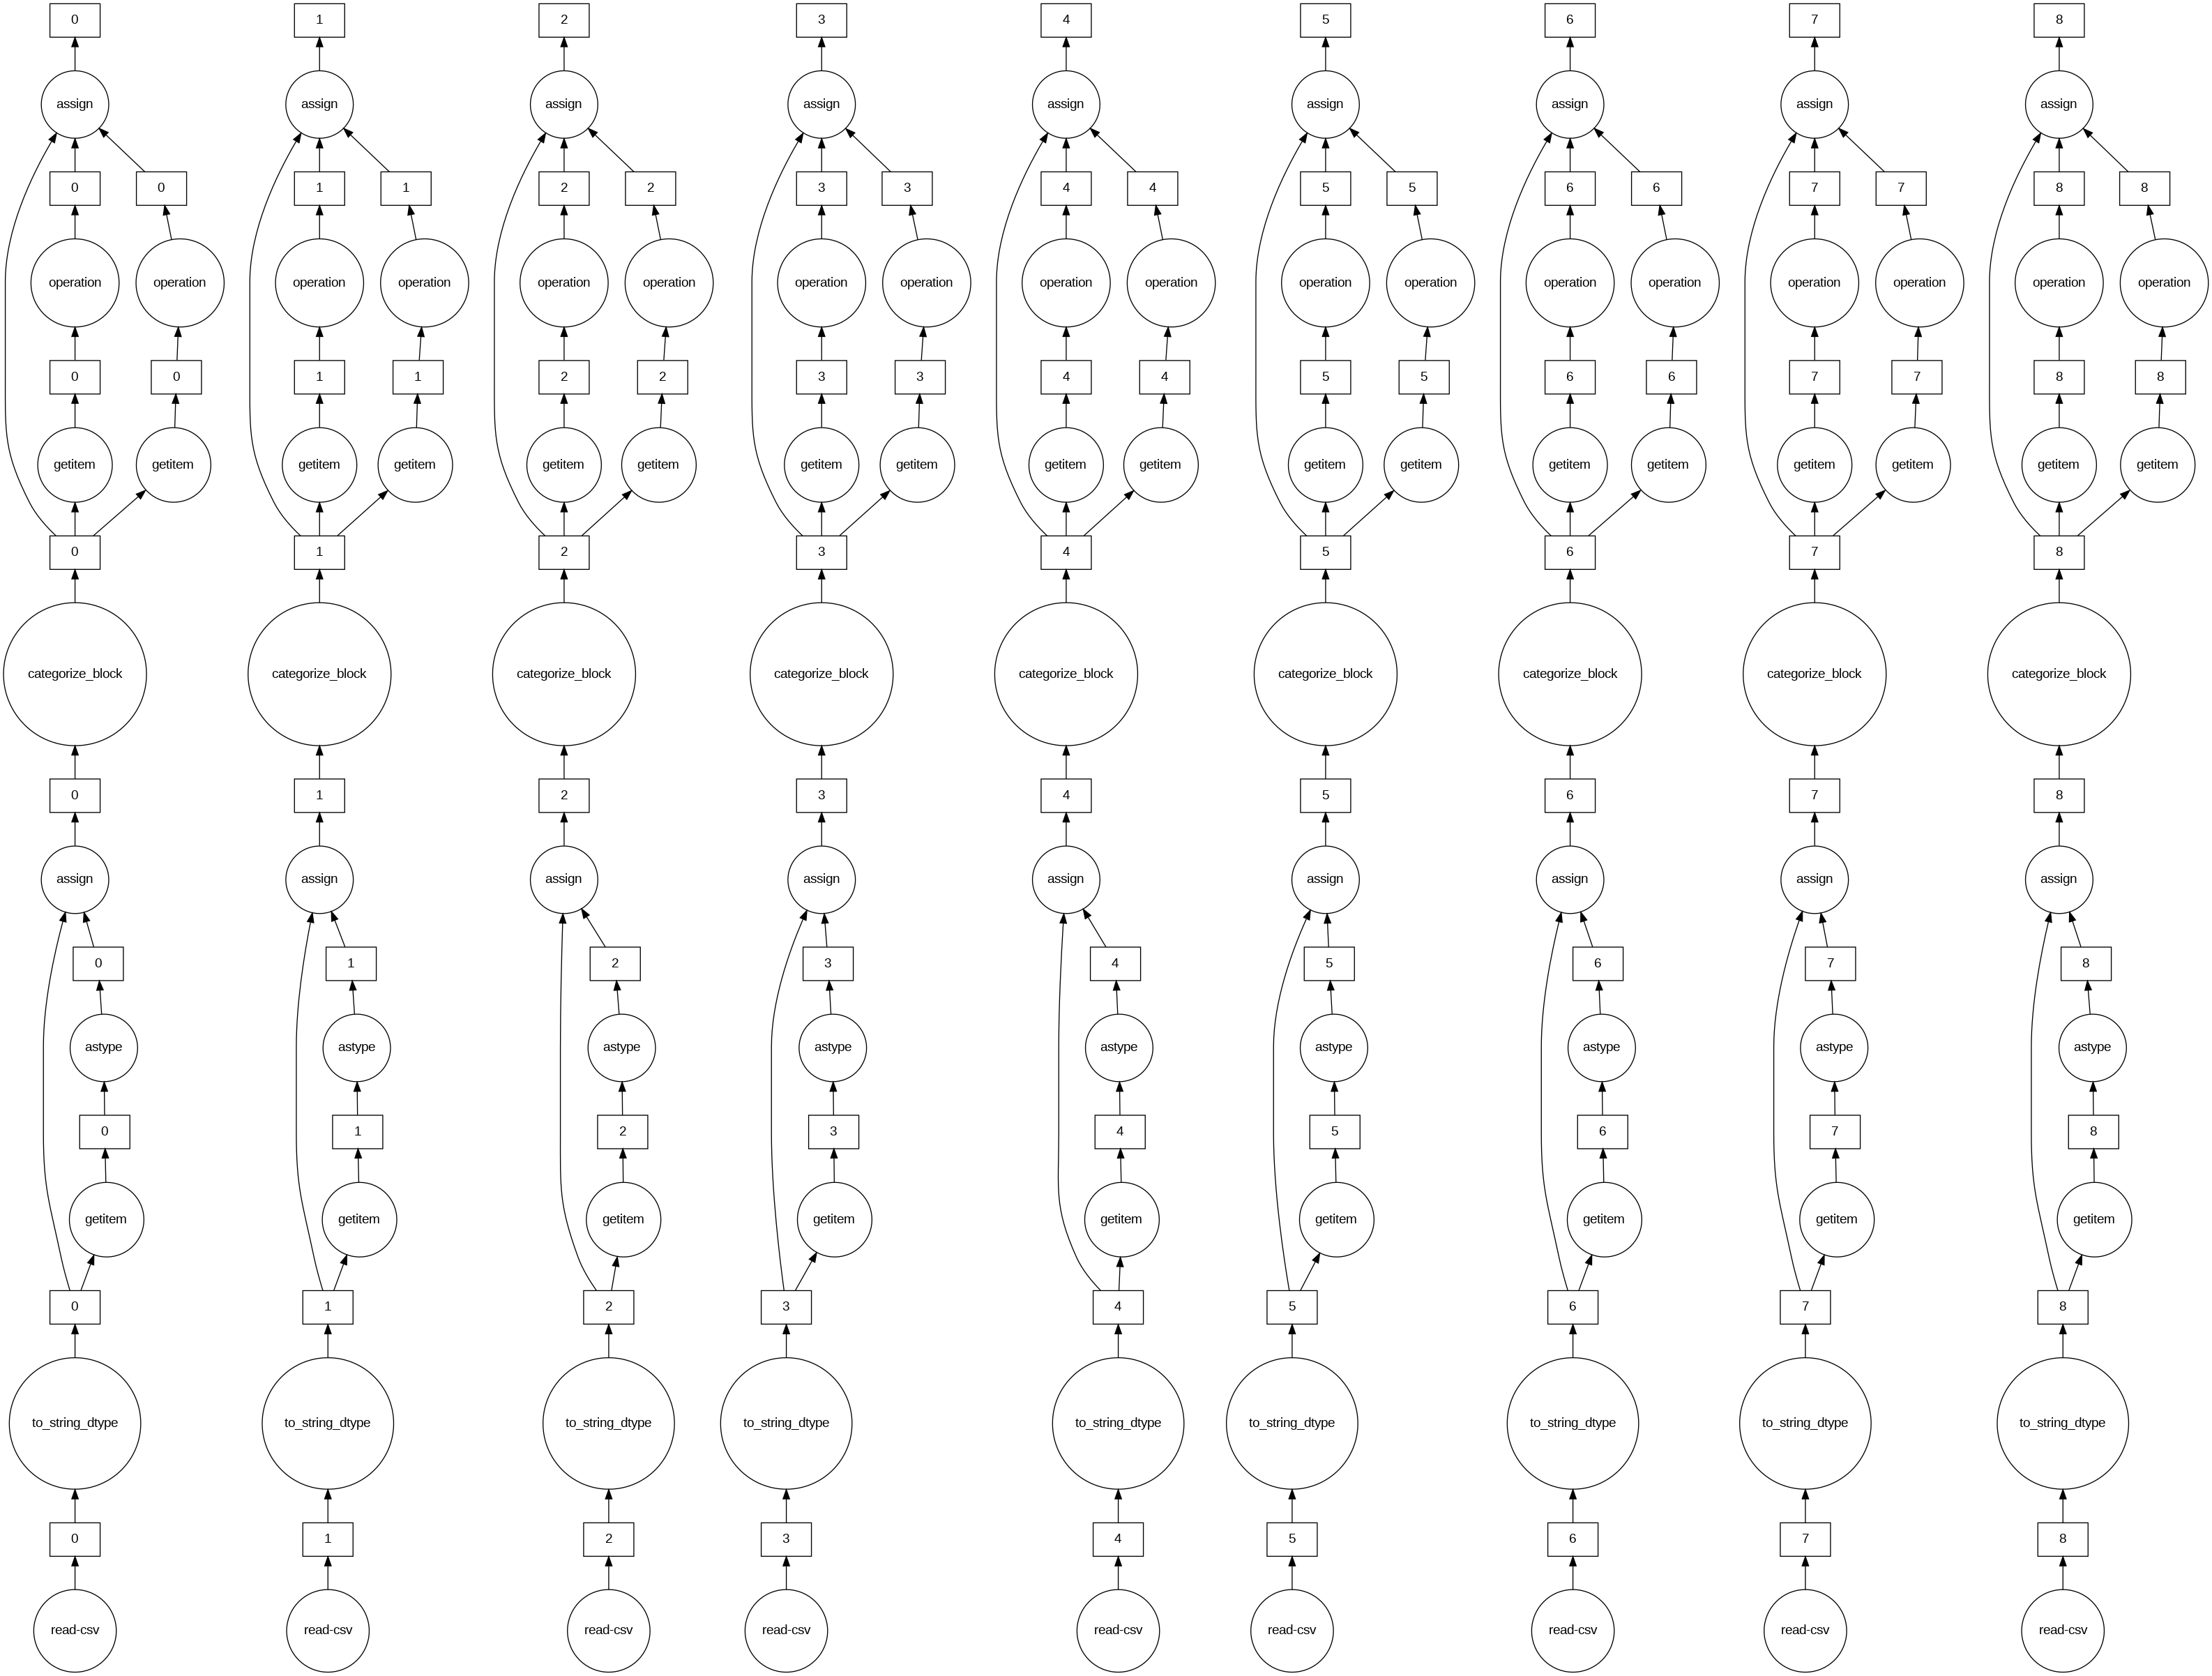

In [19]:
df.visualize(tasks=True)

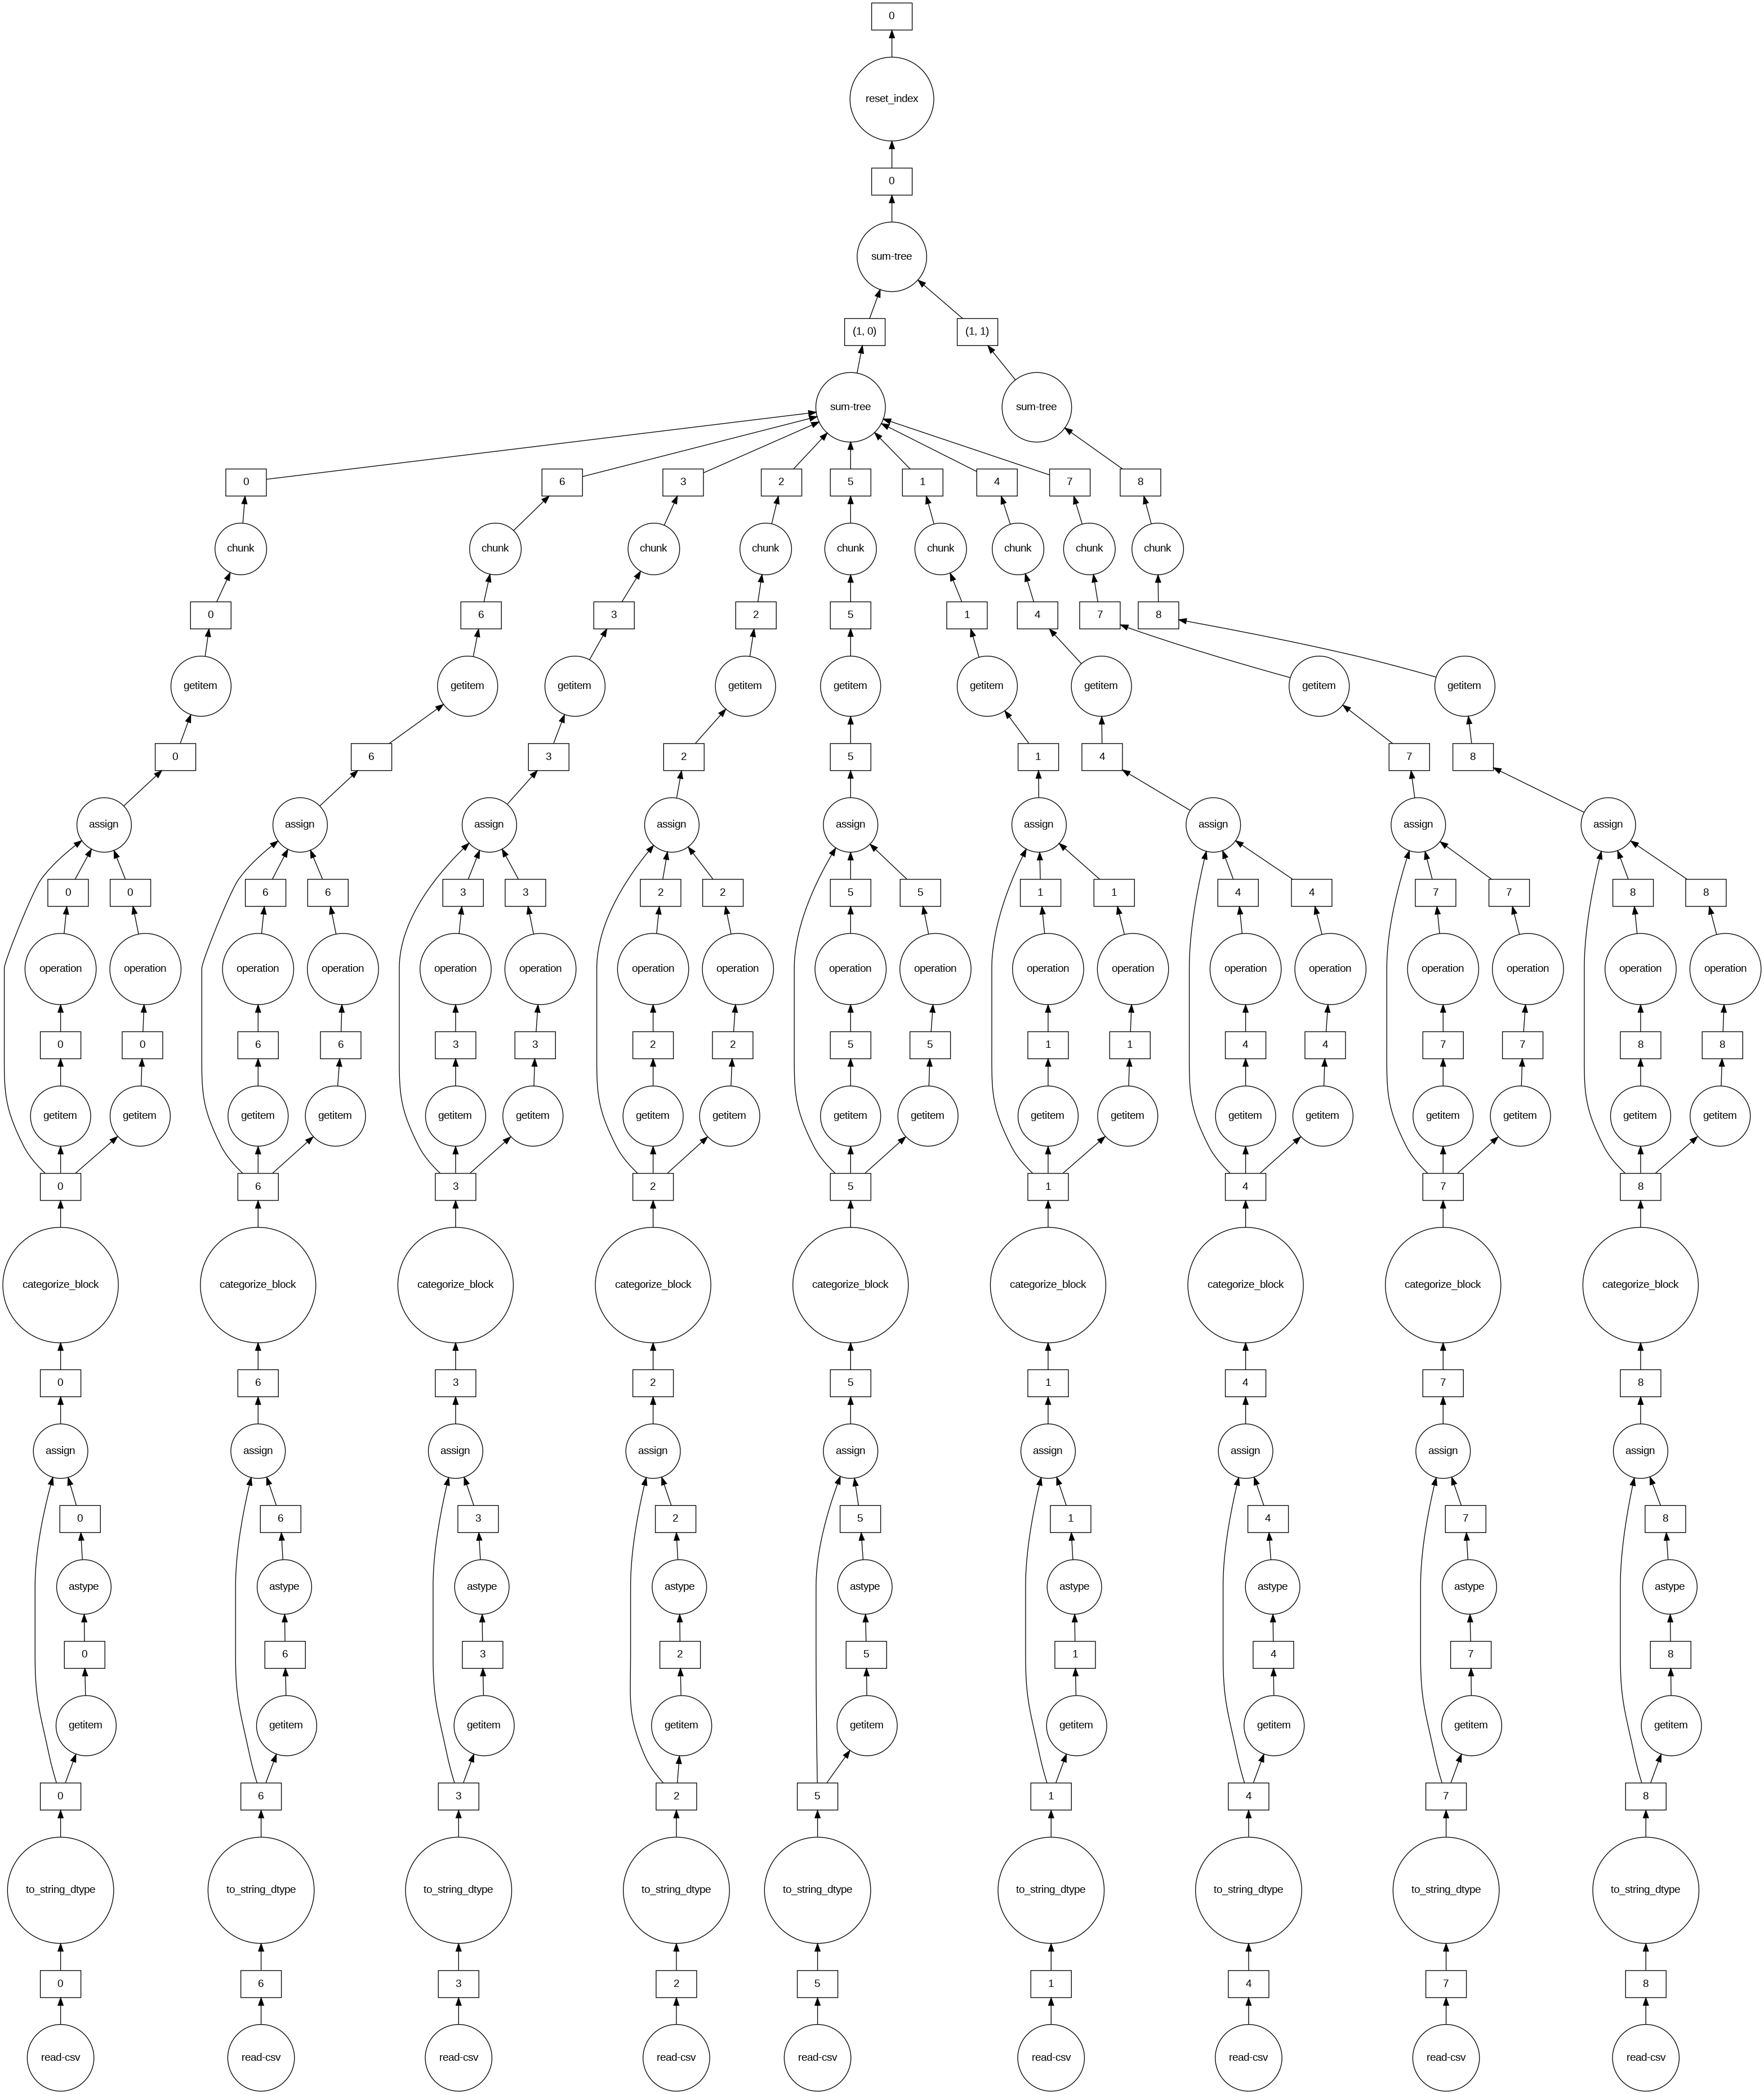

In [20]:
# Step 4: Compute the interaction matrix
# Dask doesn't support pivot tables directly, so we aggregate manually
interaction_array = df.groupby(['track_idx', 'user_idx'])['playcount'].sum().reset_index()

interaction_array.visualize(tasks=True)

In [21]:
interaction_array

,track_idx,user_idx,playcount
npartitions=1,,,
,int16,int32,float64
,...,...,...


In [22]:
interaction_array = interaction_array.compute()

In [23]:
interaction_array

,track_idx,user_idx,playcount
0,0,15780,3.0
1,0,76968,1.0
2,0,134525,2.0
3,0,231541,1.0
4,0,305348,1.0
...,...,...,...
9711296,30458,902360,1.0
9711297,30458,913310,1.0
9711298,30458,922319,1.0
9711299,30458,925779,1.0


In [24]:
# Step 5: Create a sparse matrix
# Collect the data into a NumPy-friendly format

row_indices = interaction_array['track_idx']
col_indices = interaction_array['user_idx']
values = interaction_array['playcount']

In [25]:
row_indices.nunique()

30459

In [26]:
# Build a sparse matrix
n_tracks = unique_tracks
n_users = unique_users

sparse_matrix = csr_matrix((values, (row_indices, col_indices)), shape=(n_tracks, n_users))

print("Sparse matrix shape:", sparse_matrix.shape)
print("Non-zero elements:", sparse_matrix.nnz)

Sparse matrix shape: (30459, 962037)
Non-zero elements: 9711301


In [27]:
sparse_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 9711301 stored elements and shape (30459, 962037)>

In [28]:
(sparse_matrix.nnz / (sparse_matrix.shape[0] * sparse_matrix.shape[1]))*100

0.033141335019756815

In [29]:
sparse_matrix[0]

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 161 stored elements and shape (1, 962037)>

In [30]:
from sklearn.metrics.pairwise import cosine_similarity

In [31]:
np.where(df['track_id'].cat.categories == "TROINZB128F932F740")

(array([17018]),)

In [32]:
ind = 17018

In [33]:
input_array = sparse_matrix[ind]

input_array

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 610 stored elements and shape (1, 962037)>

In [34]:
similarity_scores = cosine_similarity(input_array, sparse_matrix)

In [36]:
np.sort(similarity_scores)[-6:][::-1]

array([[0.        , 0.        , 0.        , ..., 0.07217127, 0.08225488,
        1.        ]])

In [38]:
np.argsort(similarity_scores.ravel())[-6:][::-1]

array([17018, 24529, 28964,  3620,  9470,  7882])

In [39]:
recommendations = df['track_id'].cat.categories[np.argsort(similarity_scores.ravel())[-6:][::-1]]

In [40]:
recommendations

Index(['TROINZB128F932F740', 'TRURCEI12903CA4395', 'TRYLWIW12903CA438D',
       'TRCVMAF12903D00E61', 'TRHRNEE12903CFDBD4', 'TRGEUXY128F4226B26'],
      dtype='string', name='track_id')

In [41]:
filtered_songs[filtered_songs["name"] == "Crazy in Love"]

,track_id,name,artist,spotify_preview_url
3337,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...


In [42]:
filtered_songs[filtered_songs["track_id"].isin(recommendations)]

,track_id,name,artist,spotify_preview_url
3337,TROINZB128F932F740,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...
8871,TRCVMAF12903D00E61,Delirium,Satyricon,https://p.scdn.co/mp3-preview/d039120c4f5f1e8d...
17287,TRGEUXY128F4226B26,Monday Massacre,Mr. Oizo,https://p.scdn.co/mp3-preview/4d6dbacc93e3ef7e...
26611,TRYLWIW12903CA438D,Dreadlock,Future Prophecies,https://p.scdn.co/mp3-preview/13ca5435549b0e46...
26701,TRURCEI12903CA4395,Bring the Noise,Future Prophecies,https://p.scdn.co/mp3-preview/d558b155fb9dcfe4...
27774,TRHRNEE12903CFDBD4,Lunar Sea,Camel,https://p.scdn.co/mp3-preview/8bf35f13a0ece173...


In [43]:
def collaborative_recommendation(song_name,user_data,songs_data,interaction_matrix,k=5):
    # fetch the row from songs data
    song_row = songs_data[songs_data["name"] == song_name]
    print(song_row)
    # track_id of input song
    input_track_id = song_row['track_id'].values.item()
    print(input_track_id)
    # index value of track_id
    ind = np.where(user_data['track_id'].cat.categories == input_track_id)[0].item()
    print(ind)
    # fetch the input vector
    input_array = interaction_matrix[ind]
    # get similarity scores
    similarity_scores = cosine_similarity(input_array, interaction_matrix)
    # get top k recommendations
    recommendation_track_ids = df['track_id'].cat.categories[np.argsort(similarity_scores.ravel())[-k-1:][::-1]]
    print(recommendation_track_ids)
    # get top scores
    top_scores = np.sort(similarity_scores.ravel())[-k-1:][::-1]
    print(top_scores)
    # get the songs from data and print
    temp_df = pd.DataFrame({"track_id":recommendation_track_ids.tolist(),
                            "score":top_scores})
    print(temp_df)
    top_k_songs = (
                    songs_data
                    .loc[songs_data["track_id"].isin(recommendation_track_ids)]
                    .merge(temp_df,on="track_id")
                    .sort_values(by="score",ascending=False)
                    .drop(columns=["track_id","score"])
                    .reset_index(drop=True)
                    )
    return top_k_songs

In [44]:
collaborative_recommendation(song_name="Crazy in Love",
                             user_data=df,
                             songs_data=filtered_songs,
                             interaction_matrix=sparse_matrix)

                track_id           name   artist  \
3337  TROINZB128F932F740  Crazy in Love  Beyoncé   

                                    spotify_preview_url  
3337  https://p.scdn.co/mp3-preview/807828ea7070bda7...  
TROINZB128F932F740
17018
Index(['TROINZB128F932F740', 'TRURCEI12903CA4395', 'TRYLWIW12903CA438D',
       'TRCVMAF12903D00E61', 'TRHRNEE12903CFDBD4', 'TRGEUXY128F4226B26'],
      dtype='string', name='track_id')
[1.         0.08225488 0.07217127 0.05592032 0.05529279 0.05404559]
             track_id     score
0  TROINZB128F932F740  1.000000
1  TRURCEI12903CA4395  0.082255
2  TRYLWIW12903CA438D  0.072171
3  TRCVMAF12903D00E61  0.055920
4  TRHRNEE12903CFDBD4  0.055293
5  TRGEUXY128F4226B26  0.054046


,name,artist,spotify_preview_url
0,Crazy in Love,Beyoncé,https://p.scdn.co/mp3-preview/807828ea7070bda7...
1,Bring the Noise,Future Prophecies,https://p.scdn.co/mp3-preview/d558b155fb9dcfe4...
2,Dreadlock,Future Prophecies,https://p.scdn.co/mp3-preview/13ca5435549b0e46...
3,Delirium,Satyricon,https://p.scdn.co/mp3-preview/d039120c4f5f1e8d...
4,Lunar Sea,Camel,https://p.scdn.co/mp3-preview/8bf35f13a0ece173...
5,Monday Massacre,Mr. Oizo,https://p.scdn.co/mp3-preview/4d6dbacc93e3ef7e...
